# 04. RNN with Context-Free Embeddings
In this module. we still using pretrained context-free embeddings (GloVe and FastText) with more advanced model, the recurrent neural network (RNN) 

First, we redeploy our training pipeline template from the previous module

## Training Pipeline Template
### Data Set Initiation 

In [1]:
# import data set
import pandas as pd
df = pd.read_csv("data/cleaned-train-tweets.csv", sep="|")

# create PyTorch data set
import torch
from torch.utils.data import Dataset
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

class DisasterTweetsDataset(Dataset):
    def __init__(self, df, max_vocab_size, vocabulary = None):
        
        # load dataframe
        self.x = df["clean_text"]
        self.y = df["target"]

        # create vocabulary
        if not vocabulary:
            self.vocab = build_vocab_from_iterator(
                [" ".join([str(text) for text in df["clean_text"]]).split()],
                specials=['<unk>'],
                max_tokens = max_vocab_size)
            self.vocab.set_default_index(self.vocab['<unk>'])
        else:
            self.vocab = vocabulary

    @property
    def vocab_size(self):
        # add one more for out of vocab words
        return len(self.vocab) + 1
    
    def get_vocab(self):
        return self.vocab

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        x = self.x[i]
        y = self.y[i]
        return (y, x)

# initiate dataset and vocabulary
dataset = DisasterTweetsDataset(df, 10000)
vocab = dataset.get_vocab()

### Context-free Word Embeddings

In [2]:
from torchtext.vocab import GloVe, FastText

glove = GloVe(name="6B")
fasttext = FastText(language="en")

# GloVe
def collate_into_glove(batch):
    """
    collate the dataset into continuous bag of words representation by using
    pretrained GloVe
    
    input:
        - batch (list(int, str)): a list of dataset in forms of label, text
        - pretrained (str): a pretrained word embedding ("GloVe", "FastText")
    return:
        - (tensor): a tensor of labels
        - (tensor): a tensor of bag of words
    """
    def text_pipeline(text):
        """
        create cbow vector for each text
        
        input:
            - text (str): a document, a text
        return:
            - (list): a cbow vector
        """

        tokens = str(text).split()
        vecs = glove.get_vecs_by_tokens(tokens)
        return list(vecs.mean(dim=0))

    label_pipeline = lambda x: int(x) - 1 
    labels, texts = [], []
    for label, text in batch:
        labels.append(int(label))
        texts.append(text_pipeline(text))
    return torch.tensor(labels, dtype=torch.int64), torch.tensor(texts)

# FastText
def collate_into_fasttext(batch):
    """
    collate the dataset into continuous bag of words representation by using
    pretrained FastText
    
    input:
        - batch (list(int, str)): a list of dataset in forms of label, text
        - pretrained (str): a pretrained word embedding ("GloVe", "FastText")
    return:
        - (tensor): a tensor of labels
        - (tensor): a tensor of bag of words
    """
    def text_pipeline(text):
        """
        create cbow vector for each text
        
        input:
            - text (str): a document, a text
        return:
            - (list): a cbow vector
        """

        tokens = str(text).split()
        vecs = fasttext.get_vecs_by_tokens(tokens)
        return list(vecs.mean(dim=0))

    label_pipeline = lambda x: int(x) - 1 
    labels, texts = [], []
    for label, text in batch:
        labels.append(int(label))
        texts.append(text_pipeline(text))
    return torch.tensor(labels, dtype=torch.int64), torch.tensor(texts)

### Training Pipeline


In [3]:
# Initiate a dataloader and split the data into train and validation dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader

def new_dataloader(dataset, collate_fn, batch_size=64, split_train_ratio=0.7):
    num_train = int(len(df) * split_train_ratio)
    num_valid = len(df) - num_train
    train_data, valid_data = random_split(
        dataset,
        [num_train, num_valid]
    )
    train_dataloader = DataLoader(
        train_data, 
        batch_size=batch_size, 
        shuffle=True,
        collate_fn=collate_fn
    )
    valid_dataloader = DataLoader(
        valid_data, 
        batch_size=batch_size,
        shuffle=False, 
        collate_fn=collate_fn)
    return (train_dataloader, valid_dataloader)

# helper function: repackage hidden
def repackage_hidden(h):
    """
    Wraps hidden states in new Tensors, to detach them from their history.
    """
    if h is None:
        return None
    elif isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)


# function for training an epoch
def train_an_epoch(dataloader, model, hidden, loss_function, optimizer, 
                   clip_grad, max_norm):
    model.train() # Sets the module in training mode.
    log_interval = 500

    for idx, (label, text) in enumerate(dataloader):
        hidden = repackage_hidden(hidden)
        model.zero_grad()
        output, hidden = model(text, hidden)
        loss = loss_function(output.view(-1, output.size(-1)), label.view(-1))
        loss.backward()
        if clip_grad:
            torch.nn.utils.clip_grad_norm_(
                parameters=model.parameters(), 
                max_norm=max_norm # default GRAD_CLIP = 1
            )
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')

# function for calculate the accuracy for a given dataloader
def get_accuracy(dataloader, model):
    model.eval()
    with torch.no_grad():
        hidden = None
        total_acc, total_count = 0, 0
        for _, (label, text) in enumerate(dataloader):
            log_probs, hidden = model(text, hidden)
            predicted_label = torch.argmax(log_probs, dim=1)
            total_acc += (predicted_label == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

# putting all together, create function for training
import matplotlib.pyplot as plt
import time

def training(dataset, collate_fn, batch_size, split_train_ratio, 
             model, epochs, loss_function, optimizer, clip_grad, max_norm):
    
    # create dataloader from dataset
    train_dataloader, valid_dataloader = new_dataloader(
        dataset, collate_fn, batch_size, split_train_ratio)

    # training
    accuracies = []
    max_val_acc = -float("inf")
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        hidden = None
        train_an_epoch(train_dataloader, model, hidden, loss_function, optimizer,
                       clip_grad, max_norm)
        accuracy = get_accuracy(valid_dataloader, model)
        accuracies.append(accuracy)
        time_taken = time.time() - epoch_start_time
        if epoch % 10 == 0:
            print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
        # persist the best model
        if accuracy > max_val_acc:
            print("the best model has validation accuracy at {}".format(accuracy))
            best_model = type(model)(
                model.rnn_type,  
                model.input_size, 
                model.hidden_size, 
                model.num_labels,
                model.num_layers, 
                model.dropout
            )
            best_model.load_state_dict(model.state_dict())
            max_val_acc = accuracy
    
    plt.plot(range(1, epochs + 1), accuracies)

## LSTM RNN

In [4]:
# Initiate an RNN classifier
from torch import nn
import torch.nn.functional as F

class RNNClassifier(nn.Module):
    """
    Initialize RNN classifier

    Args:
        - rnn_type (str): "LSTM", "BiLSTM", "GRU", "RNN_TANH", "RNN_RELU"
        - input_size (int): size of embedding vector (number of features) 
            for each word (default: 300)
        - hidden_size (int): the number of features in the hidden state (def: 300)
    """
    def __init__(self, rnn_type, input_size, hidden_size, num_labels, 
                 num_layers, dropout=0.5):
        super(RNNClassifier, self).__init__()
        self.rnn_type = rnn_type
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_labels = num_labels
        self.num_layers = num_layers
        self.dropout = dropout

        self.drop = nn.Dropout(dropout)
        if rnn_type == "LSTM":
            self.rnn = nn.LSTM(input_size=input_size,
                               hidden_size=hidden_size,
                               num_layers=num_layers,
                               dropout=dropout)
        elif rnn_type == "BiLSTM":
            self.rnn = nn.LSTM(input_size=input_size,
                               hidden_size=hidden_size,
                               num_layers=num_layers,
                               dropout=dropout,
                               bidirectional=True)
        elif rnn_type == "GRU":
            self.rnn = nn.GRU(input_size=input_size,
                              hidden_size=hidden_size,
                              num_layers=num_layers,
                              dropout=dropout)
        elif rnn_type == "RNN_TANH":
            self.rnn = nn.RNN(input_size=input_size,
                              hidden_size=hidden_size,
                              num_layers=num_layers,
                              nonlinearity="tanh",
                              dropout=dropout)
        elif rnn_type == "RNN_RELU":
            self.rnn = nn.RNN(input_size=input_size,
                              hidden_size=hidden_size,
                              num_layers=num_layers,
                              nonlinearity="relu",
                              dropout=dropout)

        self.decoder = nn.Linear(in_features=hidden_size, 
                                 out_features=num_labels)
        
    
    def forward(self, input, hidden0):
        drop_input = self.drop(input)
        output, hidden = self.rnn(drop_input, hidden0)
        output = self.drop(output)
        decoded_output = self.decoder(output)
        decoded_output = F.log_softmax(self.decoder(output), dim=1)
        return decoded_output, hidden
        # return F.log_softmax(self.linear(bow_vec), dim=1)

## Training Models
### Base RNN Model
#### Glove

the best model has validation accuracy at 0.5896788163118007
the best model has validation accuracy at 0.6699747383616023
the best model has validation accuracy at 0.7582100324792493
the best model has validation accuracy at 0.7782389029231325
the best model has validation accuracy at 0.786178274990978
After epoch 10 the validation accuracy is 0.786.
the best model has validation accuracy at 0.7939372067845543
the best model has validation accuracy at 0.7966438108985926
the best model has validation accuracy at 0.7998917358354385
After epoch 20 the validation accuracy is 0.767.
the best model has validation accuracy at 0.8000721761097077
the best model has validation accuracy at 0.8060267051605918
After epoch 30 the validation accuracy is 0.804.
the best model has validation accuracy at 0.8099963911945146
the best model has validation accuracy at 0.8108985925658607
After epoch 40 the validation accuracy is 0.740.
the best model has validation accuracy at 0.8116203536629376
the best mod

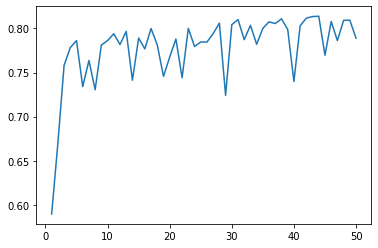

In [5]:
# Base LSTM Model
lstm_model = RNNClassifier(
    rnn_type="LSTM",
    input_size=300,
    hidden_size=300,
    num_labels=2,
    num_layers=2,
    dropout=0.5
)

# initialize parameters
DATASET = dataset
COLLATE_FN = collate_into_glove
BATCH_SIZE = 64
SPLIT_TRAIN_RATIO = 0.7
MODEL = lstm_model
EPOCHS = 50
LOSS_FUNCTION = torch.nn.NLLLoss()
OPTIMIZER = torch.optim.SGD(MODEL.parameters(), lr=1)
CLIP_GRAD = True
MAX_NORM = 1

training(DATASET, COLLATE_FN, BATCH_SIZE, SPLIT_TRAIN_RATIO, MODEL, EPOCHS, 
         LOSS_FUNCTION, OPTIMIZER, CLIP_GRAD, MAX_NORM)

#### FastText

the best model has validation accuracy at 0.5709130277878023
the best model has validation accuracy at 0.6970407795019848
the best model has validation accuracy at 0.7024539877300614
the best model has validation accuracy at 0.7937567665102851
After epoch 10 the validation accuracy is 0.718.
the best model has validation accuracy at 0.7989895344640924
the best model has validation accuracy at 0.8015156983038614
After epoch 20 the validation accuracy is 0.792.
the best model has validation accuracy at 0.8025983399494767
After epoch 30 the validation accuracy is 0.636.
the best model has validation accuracy at 0.8063875857091303
After epoch 40 the validation accuracy is 0.795.
the best model has validation accuracy at 0.8069289065319379
After epoch 50 the validation accuracy is 0.789.


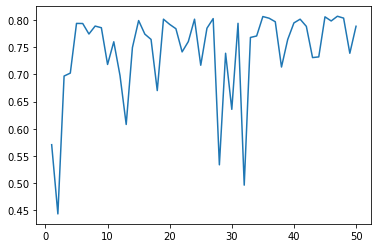

In [6]:
# Base LSTM Model
lstm_model = RNNClassifier(
    rnn_type="LSTM",
    input_size=300,
    hidden_size=300,
    num_labels=2,
    num_layers=2,
    dropout=0.5
)

# initialize parameters
DATASET = dataset
COLLATE_FN = collate_into_fasttext
BATCH_SIZE = 64
SPLIT_TRAIN_RATIO = 0.7
MODEL = lstm_model
EPOCHS = 50
LOSS_FUNCTION = torch.nn.NLLLoss()
OPTIMIZER = torch.optim.SGD(MODEL.parameters(), lr=1)
CLIP_GRAD = True
MAX_NORM = 1

training(DATASET, COLLATE_FN, BATCH_SIZE, SPLIT_TRAIN_RATIO, MODEL, EPOCHS, 
         LOSS_FUNCTION, OPTIMIZER, CLIP_GRAD, MAX_NORM)


### BiLSTM
#### GloVe


In [7]:
# Bidirectional LSTM Model
bilstm_model = RNNClassifier(
    rnn_type="BiLSTM",
    input_size=300,
    hidden_size=300,
    num_labels=2,
    num_layers=2,
    dropout=0.5
)

# initialize parameters
DATASET = dataset
COLLATE_FN = collate_into_glove
BATCH_SIZE = 64
SPLIT_TRAIN_RATIO = 0.7
MODEL = bilstm_model
EPOCHS = 50
LOSS_FUNCTION = torch.nn.NLLLoss()
OPTIMIZER = torch.optim.SGD(MODEL.parameters(), lr=1)
CLIP_GRAD = True
MAX_NORM = 1

training(DATASET, COLLATE_FN, BATCH_SIZE, SPLIT_TRAIN_RATIO, MODEL, EPOCHS, 
         LOSS_FUNCTION, OPTIMIZER, CLIP_GRAD, MAX_NORM)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x600 and 300x2)

#### FastText

In [ ]:
# Bidirectional LSTM Model
bilstm_model = RNNClassifier(
    rnn_type="BiLSTM",
    input_size=300,
    hidden_size=300,
    num_labels=2,
    num_layers=2,
    dropout=0.5
)

# initialize parameters
DATASET = dataset
COLLATE_FN = collate_into_fasttext
BATCH_SIZE = 64
SPLIT_TRAIN_RATIO = 0.7
MODEL = bilstm_model
EPOCHS = 50
LOSS_FUNCTION = torch.nn.NLLLoss()
OPTIMIZER = torch.optim.SGD(MODEL.parameters(), lr=1)
CLIP_GRAD = True
MAX_NORM = 1

training(DATASET, COLLATE_FN, BATCH_SIZE, SPLIT_TRAIN_RATIO, MODEL, EPOCHS, 
         LOSS_FUNCTION, OPTIMIZER, CLIP_GRAD, MAX_NORM)